In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.plotting import plot_decision_regions
sns.set_theme()
import torch
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, MinMaxScaler
from sklearn import metrics
from scipy.stats import zscore
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score,classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [97]:
math_file_path = "/Users/sarahchamoun/Downloads/student_performance_mathematics.csv"

In [98]:
por_file_path = "/Users/sarahchamoun/Downloads/student_portugese_performance.csv"

In [99]:
mat_data = pd.read_csv(math_file_path, sep=';')
por_data = pd.read_csv(por_file_path, sep=';')

In [100]:
print(mat_data.head())

  school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  ...  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher  ...   
1     GP   F   17       U     GT3       T     1     1  at_home     other  ...   
2     GP   F   15       U     LE3       T     1     1  at_home     other  ...   
3     GP   F   15       U     GT3       T     4     2   health  services  ...   
4     GP   F   16       U     GT3       T     3     3    other     other  ...   

  famrel freetime  goout  Dalc  Walc health absences  G1  G2  G3  
0      4        3      4     1     1      3        6   5   6   6  
1      5        3      3     1     1      3        4   5   5   6  
2      4        3      2     2     3      3       10   7   8  10  
3      3        2      2     1     1      5        2  15  14  15  
4      4        3      2     1     2      5        4   6  10  10  

[5 rows x 33 columns]


In [101]:
print(por_data.head())

  school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  ...  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher  ...   
1     GP   F   17       U     GT3       T     1     1  at_home     other  ...   
2     GP   F   15       U     LE3       T     1     1  at_home     other  ...   
3     GP   F   15       U     GT3       T     4     2   health  services  ...   
4     GP   F   16       U     GT3       T     3     3    other     other  ...   

  famrel freetime  goout  Dalc  Walc health absences  G1  G2  G3  
0      4        3      4     1     1      3        4   0  11  11  
1      5        3      3     1     1      3        2   9  11  11  
2      4        3      2     2     3      3        6  12  13  12  
3      3        2      2     1     1      5        0  14  14  14  
4      4        3      2     1     2      5        0  11  13  13  

[5 rows x 33 columns]


In [102]:
for data in [mat_data, por_data]:
    data['avg_grade'] = (data['G1'] + data['G2']) / 2
    data['grade_growth'] = data['G2'] - data['G1']

In [103]:
def preprocess(data):
    data = data.copy()
    label_cols = data.select_dtypes(include='object').columns
    le = LabelEncoder()
    for col in label_cols:
        data[col] = le.fit_transform(data[col])
    return data

In [104]:
mat_data = preprocess(mat_data)
por_data = preprocess(por_data)

In [105]:
x_train = mat_data.drop(["G3","G2","G1"], axis=1)
y_train = mat_data["G3"]
x_test = por_data.drop(["G3","G2","G1"], axis=1)
y_test = por_data["G3"]

In [106]:
scaler = StandardScaler()
x_trained_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [107]:
rf = RandomForestRegressor(random_state=42)

# Grid Search
grid_params = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}
grid_search = GridSearchCV(estimator=rf, param_grid=grid_params, 
                           scoring='r2', cv=5, n_jobs=-1)
grid_search.fit(x_trained_scaled, y_train)
best_grid_model = grid_search.best_estimator_

# Randomized Search
random_params = {
    'n_estimators': np.arange(50, 200, 10),
    'max_depth': [None] + list(np.arange(5, 30, 5)),
    'min_samples_split': [2, 5, 10]
}
random_search = RandomizedSearchCV(estimator=rf, param_distributions=random_params, 
                                   n_iter=20, scoring='r2', cv=5, random_state=42, n_jobs=-1)
random_search.fit(x_trained_scaled, y_train)
best_random_model = random_search.best_estimator_

# Evaluate both tuned models
for name, model in [("GridSearchCV", best_grid_model), ("RandomizedSearchCV", best_random_model)]:
    preds = model.predict(x_test_scaled)
    print(f"{name} - R2: {r2_score(y_test, preds):.4f}, MAE: {mean_absolute_error(y_test, preds):.4f}, RMSE: {np.sqrt(mean_squared_error(y_test, preds)):.4f}")


GridSearchCV - R2: 0.7567, MAE: 1.0477, RMSE: 1.5924
RandomizedSearchCV - R2: 0.7570, MAE: 1.0494, RMSE: 1.5914


In [108]:
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "Neural Network": MLPRegressor(hidden_layer_sizes=(128, 64, 32), activation='relu', solver='adam', alpha=0.001, early_stopping=True, max_iter=2000, random_state=42)
}

In [109]:
results=[]

In [110]:
for name, model in models.items():
    model.fit(x_trained_scaled, y_train)
    preds = model.predict(x_test_scaled)
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)
    results.append({"Model": name, "MAE": mae, "RMSE": rmse, "R2 Score": r2})

In [111]:
# for name, model in models.items():
#     if name == "Linear Regression":
#         model.fit(x_train, y_train)
#         preds=model.predict(x_test)
#     else: 
#         model.fit(x_trained_scaled, y_train)
#         preds=model.predict(x_test_scaled)

In [112]:
mae = mean_absolute_error(y_test,preds)
rmse = np.sqrt(mean_absolute_error(y_test,preds))
r2 = r2_score(y_test, preds)
results.append({"Model": name, "MAE": round(mae, 4), "RMSE": round(rmse, 4), "R2 Score": round(r2, 4)})

In [113]:
results_df = pd.DataFrame(results).drop_duplicates(subset=["Model"])
print("\nCross-Dataset Evaluation (Train on MAT, Test on POR):")
print(results_df)


Cross-Dataset Evaluation (Train on MAT, Test on POR):
               Model       MAE      RMSE  R2 Score
0  Linear Regression  1.144644  1.576532  0.761497
1      Random Forest  1.068290  1.611525  0.750792
2  Gradient Boosting  1.106436  1.626337  0.746190
3     Neural Network  1.538264  2.071770  0.588119


In [114]:
combined_df = pd.concat([mat_data, por_data], ignore_index=True)

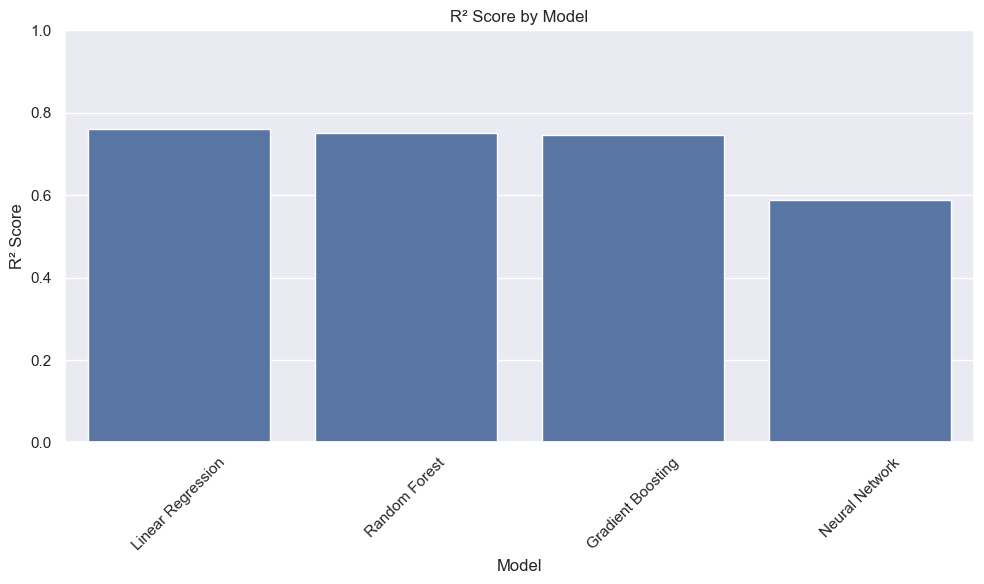

In [115]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='R2 Score', data=results_df)
plt.title('R² Score by Model')
plt.ylabel('R² Score')
plt.xlabel('Model')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

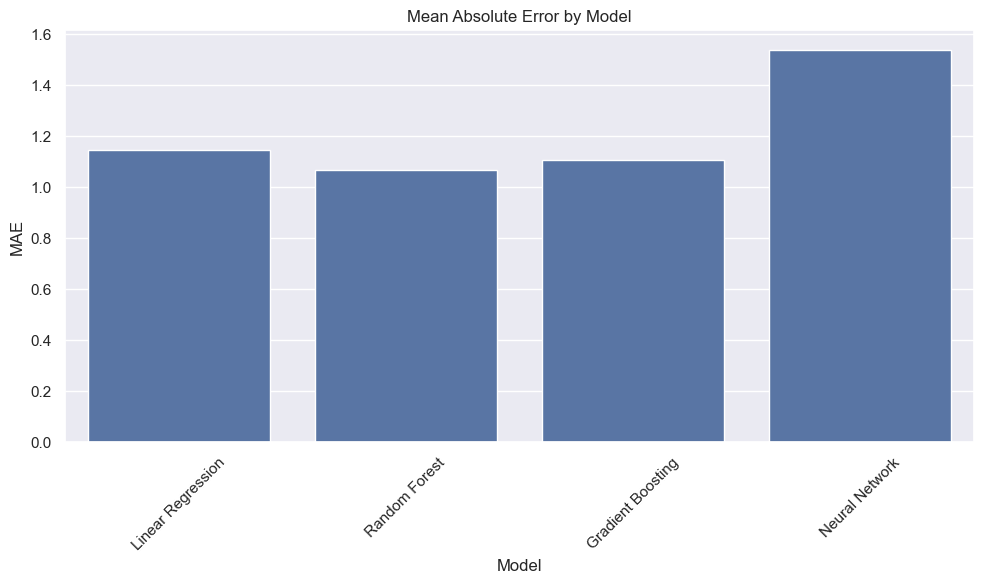

In [116]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='MAE', data=results_df)
plt.title('Mean Absolute Error by Model')
plt.ylabel('MAE')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

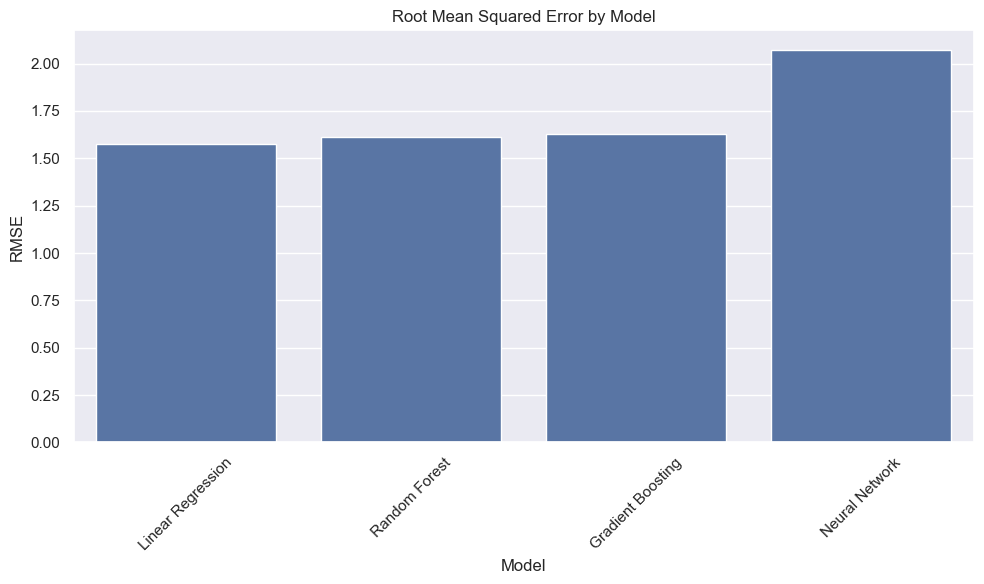

In [117]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='RMSE', data=results_df)
plt.title('Root Mean Squared Error by Model')
plt.ylabel('RMSE')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

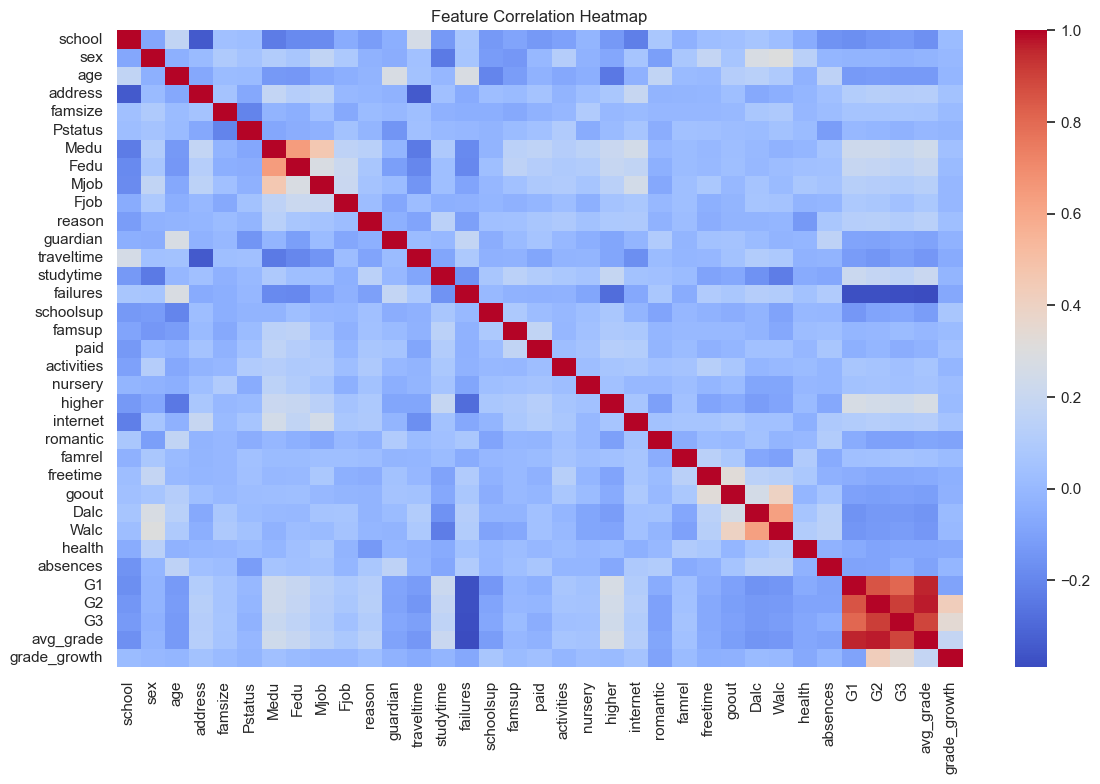

In [118]:
plt.figure(figsize=(12, 8))
sns.heatmap(combined_df.corr(), annot=False, cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.show()

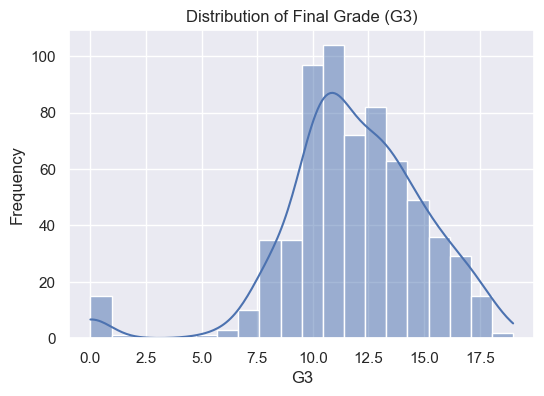

In [119]:
plt.figure(figsize=(6, 4))
sns.histplot(data['G3'], bins=20, kde=True)
plt.title("Distribution of Final Grade (G3)")
plt.xlabel("G3")
plt.ylabel("Frequency")
plt.show()

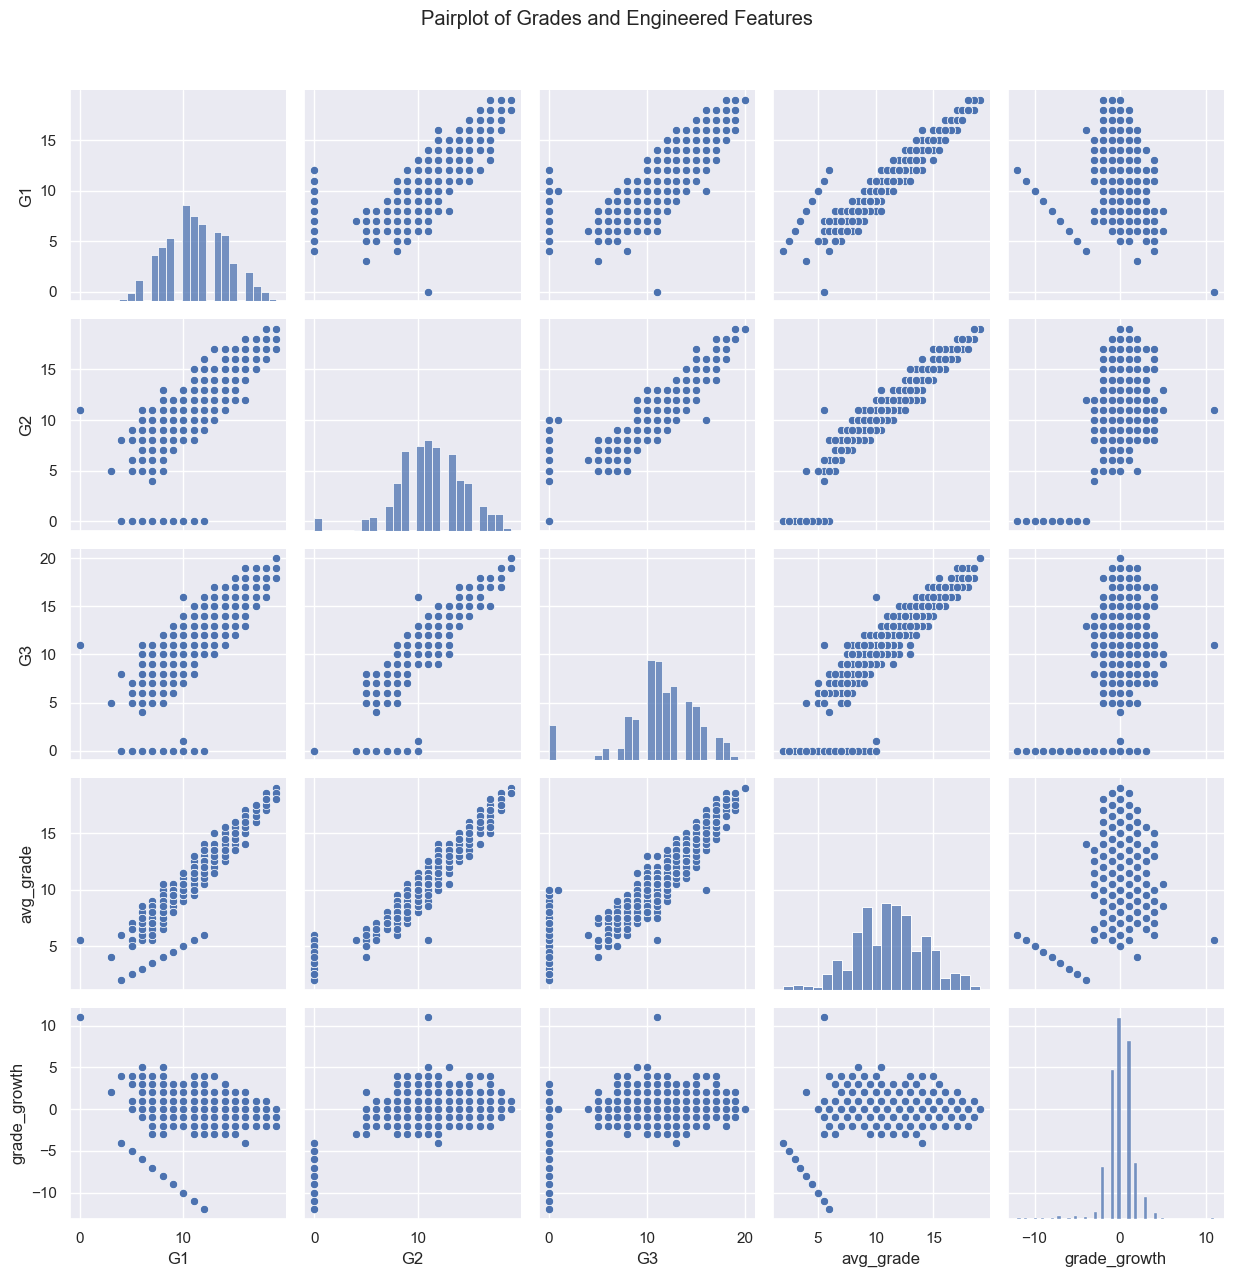

In [120]:
sns.pairplot(combined_df[['G1', 'G2', 'G3', 'avg_grade', 'grade_growth']])
plt.suptitle("Pairplot of Grades and Engineered Features", y=1.02)
plt.tight_layout()
plt.show()

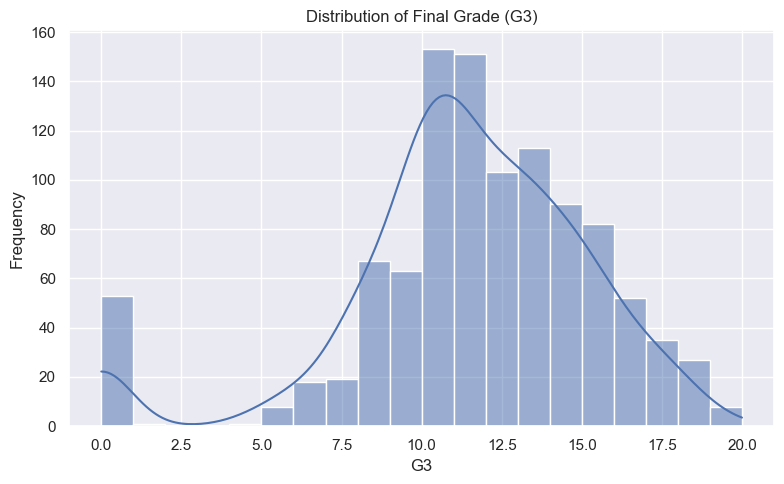

In [121]:
plt.figure(figsize=(8, 5))
sns.histplot(combined_df['G3'], bins=20, kde=True)
plt.title("Distribution of Final Grade (G3)")
plt.xlabel("G3")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

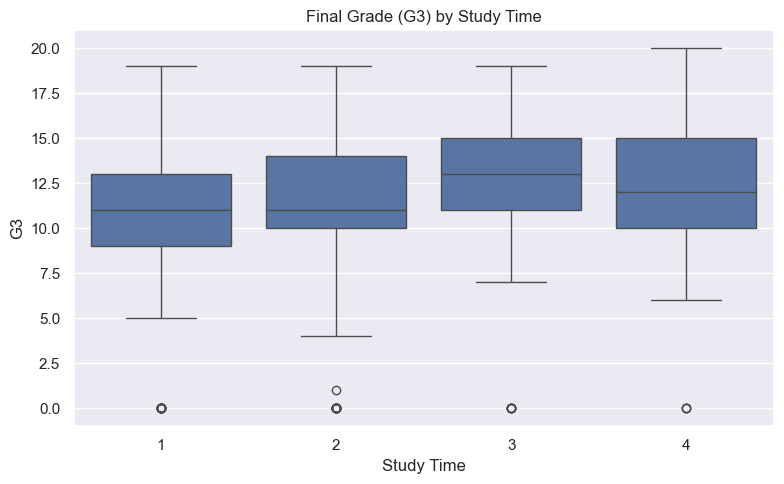

In [122]:
plt.figure(figsize=(8, 5))
sns.boxplot(x='studytime', y='G3', data=combined_df)
plt.title("Final Grade (G3) by Study Time")
plt.xlabel("Study Time")
plt.ylabel("G3")
plt.tight_layout()
plt.show()

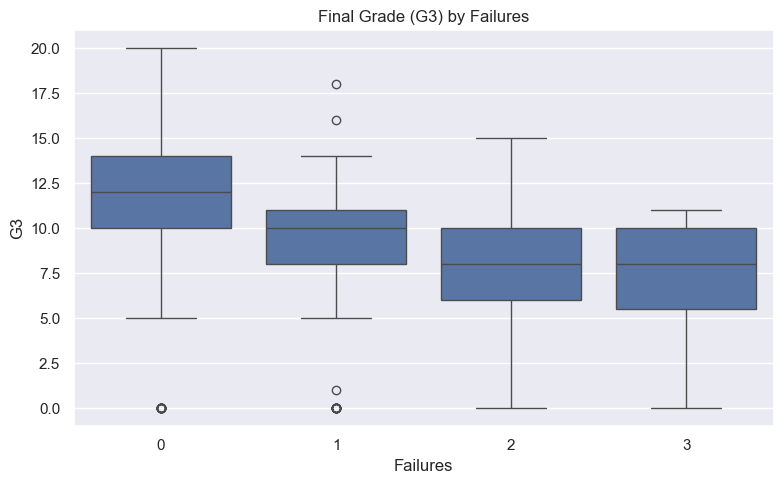

In [123]:
plt.figure(figsize=(8, 5))
sns.boxplot(x='failures', y='G3', data=combined_df)
plt.title("Final Grade (G3) by Failures")
plt.xlabel("Failures")
plt.ylabel("G3")
plt.tight_layout()
plt.show()

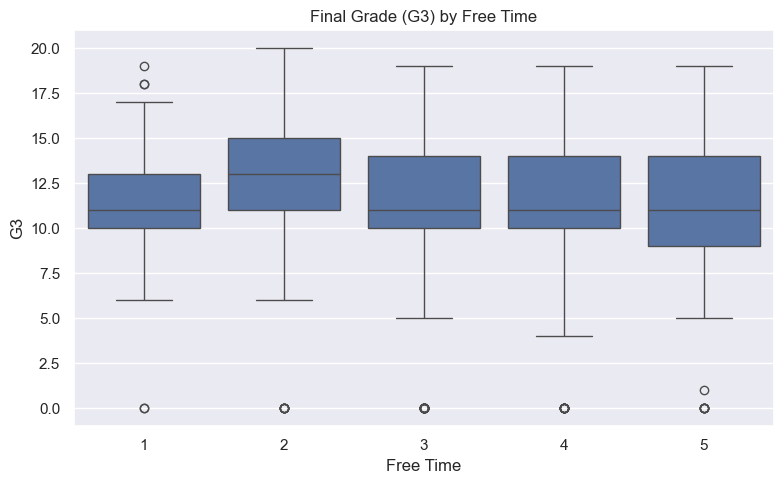

In [124]:
plt.figure(figsize=(8, 5))
sns.boxplot(x='freetime', y='G3', data=combined_df)
plt.title("Final Grade (G3) by Free Time")
plt.xlabel("Free Time")
plt.ylabel("G3")
plt.tight_layout()
plt.show()

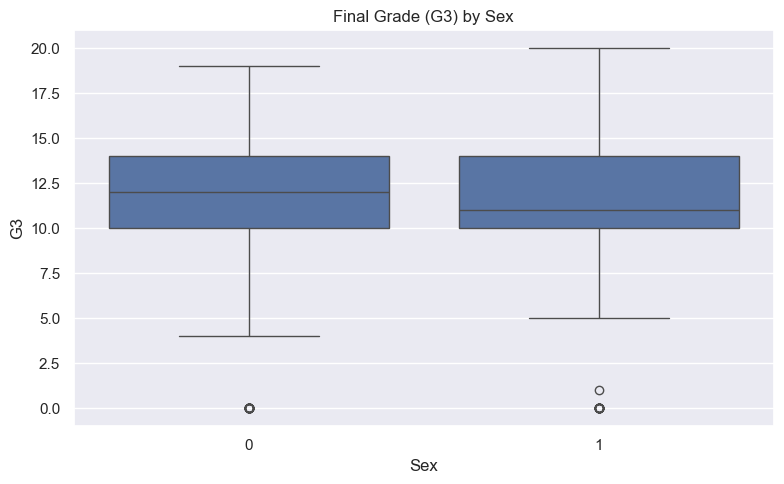

In [125]:
plt.figure(figsize=(8, 5))
sns.boxplot(x='sex', y='G3', data=combined_df)
plt.title("Final Grade (G3) by Sex")
plt.xlabel("Sex")
plt.ylabel("G3")
plt.tight_layout()
plt.show()